In [25]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [1]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import tqdm
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [3]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Testing"
image_size = (256,256)
num_classes = 4
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [6]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

In [7]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [8]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import vgg11_bn, VGG11_BN_Weights
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # load in vgg
        vgg = vgg11_bn(weights=VGG11_BN_Weights)
        num_input_features = vgg.classifier[6].in_features

        # freeze layers
        for param in vgg.parameters():
            param.requires_grad = False

        # define feed forward network
        vgg.classifier[6] = nn.Linear(num_input_features, num_classes)
        for param in vgg.classifier.parameters():
            param.requires_grad = True
            
        self.model = vgg

    def forward(self, x):
        return self.model(x)



In [10]:
# initialize params
model = Net(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [12]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [14]:
best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   Batch 150/179, Loss: 0.4419, Accuracy: 84.42%
Train Loss: 0.4161, Train Accuracy: 85.12%
Eval Loss: 0.3186, Eval Accuracy: 88.24%
Epoch 1,   Batch 150/179, Loss: 0.2736, Accuracy: 89.92%
Train Loss: 0.2719, Train Accuracy: 89.93%
Eval Loss: 0.2493, Eval Accuracy: 91.76%
Epoch 2,   Batch 150/179, Loss: 0.2170, Accuracy: 91.62%
Train Loss: 0.2155, Train Accuracy: 91.79%
Eval Loss: 0.2065, Eval Accuracy: 91.91%
Epoch 3,   Batch 150/179, Loss: 0.1845, Accuracy: 93.25%
Train Loss: 0.1892, Train Accuracy: 92.96%
Eval Loss: 0.1899, Eval Accuracy: 93.59%
Epoch 4,   Batch 150/179, Loss: 0.1554, Accuracy: 94.33%
Train Loss: 0.1616, Train Accuracy: 94.03%
Eval Loss: 0.1693, Eval Accuracy: 93.89%
Epoch 5,   Batch 150/179, Loss: 0.1497, Accuracy: 94.58%
Train Loss: 0.1452, Train Accuracy: 94.75%
Eval Loss: 0.1109, Eval Accuracy: 95.73%
Epoch 6,   Batch 150/179, Loss: 0.1370, Accuracy: 95.24%
Train Loss: 0.1327, Train Accuracy: 95.38%
Eval Loss: 0.0967, Eval Accuracy: 96.03%
Epoch 7,   Ba

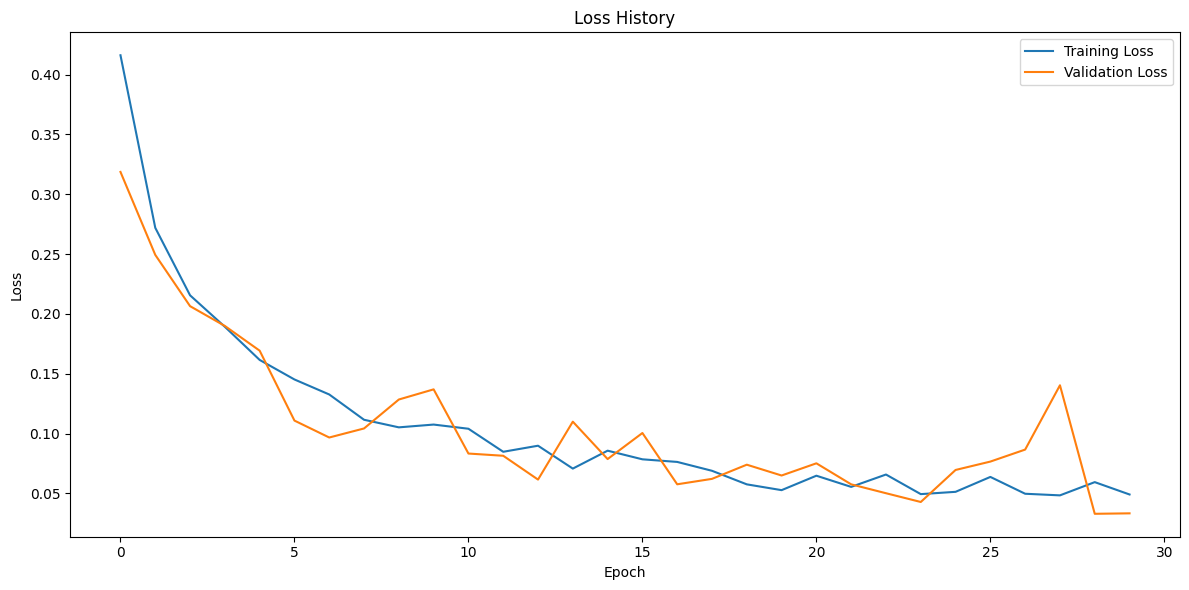

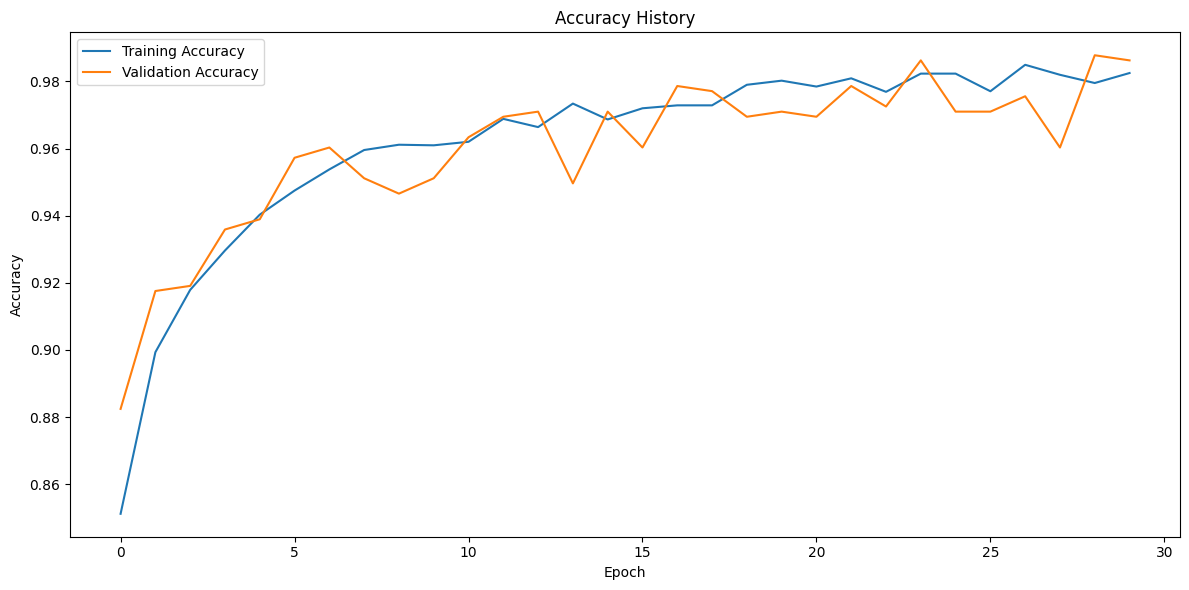

In [15]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [16]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/reseach/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_" + str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_25'

In [17]:
best_model = Net(num_classes).to(device)
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in torch.load(best_model_path, map_location=device).items() if k in model_dict}
model_dict.update(pretrained_dict)
best_model.load_state_dict(model_dict)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_25'

In [ ]:

def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [ ]:

best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

656

In [ ]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)

656

In [ ]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 0.76%


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = sorted(set(gen_labels_test_set))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

precision_per_class = precision_score(gen_labels_test_set, best_model_preds, average=None)
recall_per_class = recall_score(gen_labels_test_set, best_model_preds, average=None)
f1_per_class = f1_score(gen_labels_test_set, best_model_preds, average=None)

for i, label in enumerate(labels):
    print(f'Class: {label}')
    print(f'  Precision: {precision_per_class[i]}')
    print(f'  Recall: {recall_per_class[i]}')
    print(f'  F1 Score: {f1_per_class[i]}')


NameError: name 'best_model_preds' is not defined